env.action_space = Discrete(4)
env.observation_space = Discrete(16) 

env.action_space.n = 4
env.observation_space.n = 16 

env.reset() = (0, {'prob': 1}) 
 


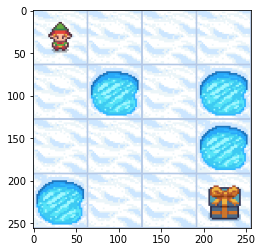

In [22]:
# Install the gymnasium package and its dependencies for this notebook.
# !pip install gymnasium
# !pip install gymnasium[toy-text]
# !pip install pygame

import gymnasium as gym

import matplotlib.pyplot as plt
import numpy as np

# Instantiate the Frozen Lake environment. Set is_slippery=False for
# deterministic environment dynamics.
env =gym.make("FrozenLake-v1", render_mode="rgb_array")

# Print the action and observation spaces.
print(f"{env.action_space = }")
print(f"{env.observation_space = } \n")

# Show the numerical number of actions and spaces.
print(f"{env.action_space.n = }")
print(f"{env.observation_space.n = } \n")

# Always reset the environment before taking actions. This sets the
# character in state 0 and returns a dictionary of information concerning
# this initial state.
print(f"{env.reset() = } \n ")

# We can view the game state by calling plt.imshow on the rgb rendering of
# the current game state.
current_grid = env.render()
plt.imshow(current_grid)
plt.show()


---

## Action Space

The action shape is `(1,)` in the range `{0, 3}` indicating which direction to move the player.

    0: Move left

    1: Move down

    2: Move right

    3: Move up



---

state = 1
reward = 0.0
done = False
_ = False
P = {'prob': 0.3333333333333333}


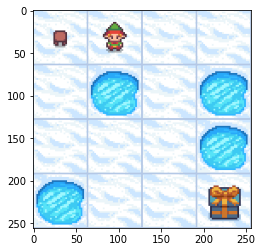

In [23]:
state, reward, done, _, P = env.step(1) # Try and move down.
print(f"{state = }")
print(f"{reward = }")
print(f"{done = }")
print(f"{_ = }")
print(f"{P = }")
new_grid = env.render()
plt.imshow(new_grid)
plt.show()

state = 0
reward = 0.0
done = False
_ = False
P = {'prob': 0.3333333333333333}


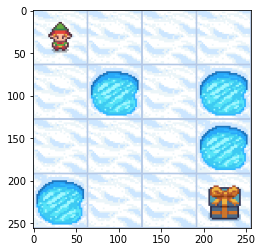

In [24]:
state, reward, done, _, P = env.step(1)
print(f"{state = }")
print(f"{reward = }")
print(f"{done = }")
print(f"{_ = }")
print(f"{P = }")
new_grid = env.render()
plt.imshow(new_grid)
plt.show()

state = 1
reward = 0.0
done = False
_ = False
P = {'prob': 0.3333333333333333}


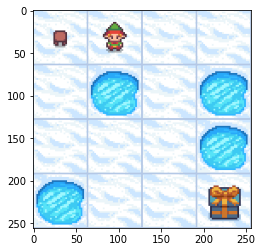

In [25]:
state, reward, done, _, P = env.step(1)
print(f"{state = }")
print(f"{reward = }")
print(f"{done = }")
print(f"{_ = }")
print(f"{P = }")
new_grid = env.render()
plt.imshow(new_grid)
plt.show()

state = 1
reward = 0.0
done = False
_ = False
P = {'prob': 0.3333333333333333}


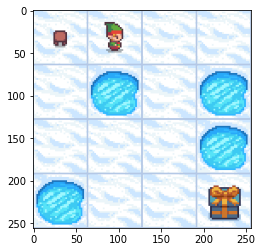

In [26]:
state, reward, done, _, P = env.step(2)
print(f"{state = }")
print(f"{reward = }")
print(f"{done = }")
print(f"{_ = }")
print(f"{P = }")
new_grid = env.render()
plt.imshow(new_grid)
plt.show()

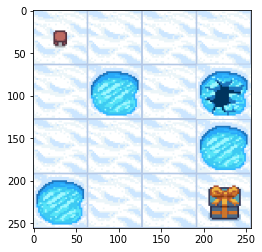

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

state, P = env.reset()
done = False
frames = [env.render()]
while not done:
    action = env.action_space.sample()
    state, reward, done, _, P = env.step(action)
    new_grid = env.render()
    frames.append(new_grid)


fig, ax = plt.subplots()

# Function to update the figure with the new frame
def update(frame):
    ax.clear()  # Clear previous frame
    ax.imshow(frame)  # Display the current frame
    return ax,

# Creating the animation
ani = FuncAnimation(fig, update, frames=frames, blit=False)

# Display the animation
HTML(ani.to_html5_video())

In [28]:
# Show the transition probabilities for each state-action pair.
print(f"{env.unwrapped.P = }")

env.unwrapped.P = {0: {0: [(0.3333333333333333, 0, 0.0, False), (0.3333333333333333, 0, 0.0, False), (0.3333333333333333, 4, 0.0, False)], 1: [(0.3333333333333333, 0, 0.0, False), (0.3333333333333333, 4, 0.0, False), (0.3333333333333333, 1, 0.0, False)], 2: [(0.3333333333333333, 4, 0.0, False), (0.3333333333333333, 1, 0.0, False), (0.3333333333333333, 0, 0.0, False)], 3: [(0.3333333333333333, 1, 0.0, False), (0.3333333333333333, 0, 0.0, False), (0.3333333333333333, 0, 0.0, False)]}, 1: {0: [(0.3333333333333333, 1, 0.0, False), (0.3333333333333333, 0, 0.0, False), (0.3333333333333333, 5, 0.0, True)], 1: [(0.3333333333333333, 0, 0.0, False), (0.3333333333333333, 5, 0.0, True), (0.3333333333333333, 2, 0.0, False)], 2: [(0.3333333333333333, 5, 0.0, True), (0.3333333333333333, 2, 0.0, False), (0.3333333333333333, 1, 0.0, False)], 3: [(0.3333333333333333, 2, 0.0, False), (0.3333333333333333, 1, 0.0, False), (0.3333333333333333, 0, 0.0, False)]}, 2: {0: [(0.3333333333333333, 2, 0.0, False), (

In [ ]:
# I need to fix this one.
def run_episodes(environment, n_episodes, policy, display=True):
    wins = 0
    total_reward = 0
    for episode in range(n_episodes):
        terminated = False
        state = environment.reset()
        while not terminated:
            # Select an action to perform in a current state
            if isinstance(policy, str) and policy == 'random':
                action = environment.action_space.sample()
            else:
                action = np.argmax(policy[state])

            # Perform an action and observe how environment acted in response
            next_state, reward, terminated, info = environment.step(action)

            # Plot the first episode
            if episode==1 and display:
                print("Action:")
                plt.imshow(environment.render()) # display current agent state
            # Summarize total reward
            total_reward += reward
            # Update current state
            state = next_state
            # Calculate number of wins over episodes
            if terminated and reward == 1.0:
                wins += 1
    average_reward = total_reward / n_episodes
    return wins, total_reward, average_reward

In [29]:
def policy_evaluation(policy, environment, discount_factor=0.99, theta=1e-9, max_iterations=1e9):
    # Number of evaluation iterations
    evaluation_iterations = 1
    # Initialize a value function for each state as zero
    V = np.zeros(environment.observation_space.n)
    # Repeat until change in value is below the threshold
    for i in range(int(max_iterations)):
        # Initialize a change of value function as zero
        delta = 0
        # Iterate though each state
        for state in range(environment.observation_space.n):
            v = V[state]
            v_a = []
            for action in range(environment.action_space.n):
                v_x = 0
                for (p, new_state, reward, terminating) in env.unwrapped.P[state][action]:
                    v_x += policy[state][action] * p * (reward + V[new_state])
                v_a.append(v_x)

                # Update value function
            V[state] = max(v_a)

            # Calculate the absolute change of value function
            delta = max(delta, np.abs(V[state] - v))
            # Update value function
            #V[state] = v
        evaluation_iterations += 1

        # Terminate if value change is insignificant
        if delta < theta:
            # TODO - check how many iterations
            print(f'Policy-evaluation converged at iteration #{evaluation_iterations}')
            return V

In [30]:
pi = {state : {0 : .25, 1 : .25, 2 : .25, 3 : .25} for state in range(env.observation_space.n)}

V = policy_evaluation(pi, env)

Policy-evaluation converged at iteration #12


In [31]:
print(f"{V = }")

V = array([1.55772390e-06, 5.61034422e-06, 6.01564709e-05, 6.01562405e-06,
       1.15261198e-05, 0.00000000e+00, 6.55705841e-04, 0.00000000e+00,
       1.25230332e-04, 1.36600788e-03, 7.80831365e-03, 0.00000000e+00,
       0.00000000e+00, 8.45855071e-03, 9.16780501e-02, 0.00000000e+00])


In [ ]:
state, P = env.reset()
done = False
frames = [env.render()]
while not done:
    action = env.action_space.sample()
    state, reward, done, _, P = env.step(action)
    new_grid = env.render()
    frames.append(new_grid)


fig, ax = plt.subplots()

# Function to update the figure with the new frame
def update(frame):
    ax.clear()  # Clear previous frame
    ax.imshow(frame)  # Display the current frame
    return ax,

# Creating the animation
ani = FuncAnimation(fig, update, frames=frames, blit=False)

# Display the animation
HTML(ani.to_html5_video())

In [32]:
def one_step_lookahead(environment, state, V, discount_factor):
    action_values = np.zeros(environment.action_space.n)
    for action in range(environment.action_space.n):
        for probability, next_state, reward, terminated in env.unwrapped.P[state][action]:
            action_values[action] += probability * (reward + discount_factor * V[next_state])
    return action_values

In [33]:
# Check that the function works!
one_step_lookahead(env, 1, V, 1.0)

array([2.38935604e-06, 2.05713983e-05, 2.19222717e-05, 2.24415130e-05])

In [34]:
def policy_iteration(environment, discount_factor=1.0, max_iterations=1e9):
    # Start with a random policy
    # num states x num actions / num actions
    policy = np.ones([environment.observation_space.n, environment.action_space.n]) / environment.action_space.n
    # Initialize counter of evaluated policies
    evaluated_policies = 1
    # Repeat until convergence or critical number of iterations reached
    for i in range(int(max_iterations)):
        stable_policy = True
        # Evaluate current policy
        V = policy_evaluation(policy, environment, discount_factor=discount_factor)

        # Go through each state and try to improve actions that were taken (policy Improvement)
        for state in range(environment.observation_space.n):
            # Choose the best action in a current state under current policy
            current_action =  policy[state].tolist().index(max(policy[state]))
            # Look one step ahead and evaluate if current action is optimal
            # We will try every possible action in a current state
            action_value = one_step_lookahead(environment, state, V, discount_factor)
            # Select a better action
            best_action = action_value.tolist().index(max(action_value))
            # If action didn't change
            if current_action != best_action:
                stable_policy = True
                # Greedy policy update
                policy[state] = np.eye(environment.action_space.n)[best_action]
        evaluated_policies += 1
        # If the algorithm converged and policy is not changing anymore, then return final policy and value function
        if stable_policy:
            return policy, V

In [35]:
policy, V = policy_iteration(env)
print(f"{policy = } \n")
print(f"{V = } \n")

Policy-evaluation converged at iteration #12
policy = array([[0.  , 1.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 1.  ],
       [0.  , 0.  , 1.  , 0.  ],
       [0.  , 0.  , 0.  , 1.  ],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.  , 0.  , 0.  , 1.  ],
       [0.  , 1.  , 0.  , 0.  ],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.  , 0.  , 1.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  ],
       [0.25, 0.25, 0.25, 0.25]]) 

V = array([1.55772390e-06, 5.61034422e-06, 6.01564709e-05, 6.01562405e-06,
       1.15261198e-05, 0.00000000e+00, 6.55705841e-04, 0.00000000e+00,
       1.25230332e-04, 1.36600788e-03, 7.80831365e-03, 0.00000000e+00,
       0.00000000e+00, 8.45855071e-03, 9.16780501e-02, 0.00000000e+00]) 



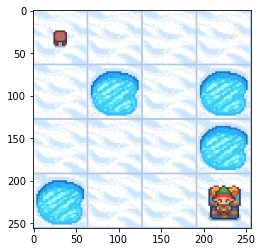

In [38]:
state, P = env.reset()
done = False
frames = [env.render()]
while not done:
    action = np.argmax(policy[state])
    state, reward, done, _, P = env.step(action)
    new_grid = env.render()
    frames.append(new_grid)
new_grid = env.render()
frames.append(new_grid)

fig, ax = plt.subplots()

# Function to update the figure with the new frame
def update(frame):
    ax.clear()  # Clear previous frame
    ax.imshow(frame)  # Display the current frame
    return ax,

# Creating the animation
ani = FuncAnimation(fig, update, frames=frames, blit=False)

# Display the animation
HTML(ani.to_html5_video())

In [39]:
def value_iteration(environment, discount_factor=1.0, theta=1e-9, max_iterations=1e9):
    # Initialize state-value function with zeros for each environment state
    V = np.zeros(environment.observation_space.n)
    for i in range(int(max_iterations)):
        # Early stopping condition
        delta = 0
        # Update each state
        for state in range(environment.observation_space.n):
            # Do a one-step lookahead to calculate state-action values
            action_value = one_step_lookahead(environment, state, V, discount_factor)
            # Select best action to perform based on the highest state-action value
            best_action_value = max(action_value)
            # Calculate change in value
            delta = max(delta, np.abs(V[state] - best_action_value))
            # Update the value function for current state
            V[state] = best_action_value
            # Check if we can stop
        if delta < theta:
            print(f'Value-iteration converged at iteration #{i}.')
            break

    # Create a deterministic policy using the optimal value function
    policy = np.zeros([environment.observation_space.n, environment.action_space.n])
    for state in range(environment.observation_space.n):
        # One step lookahead to find the best action for this state
        action_value = one_step_lookahead(environment, state, V, discount_factor)
        # Select best action based on the highest state-action value
        best_action = action_value.tolist().index(max(action_value))
        # Update the policy to perform a better action at a current state
        policy[state, best_action] = 1.0
    return policy, V

In [40]:
policy, V = value_iteration(env)
print(f"{policy = } \n")
print(f"{V = } \n")

Value-iteration converged at iteration #523.
policy = array([[1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.]]) 

V = array([0.82352939, 0.82352939, 0.82352939, 0.82352938, 0.8235294 ,
       0.        , 0.52941175, 0.        , 0.8235294 , 0.8235294 ,
       0.76470587, 0.        , 0.        , 0.88235293, 0.94117647,
       0.        ]) 



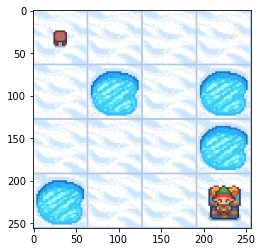

In [41]:
state, P = env.reset()
done = False
frames = [env.render()]
while not done:
    action = np.argmax(policy[state])
    state, reward, done, _, P = env.step(action)
    new_grid = env.render()
    frames.append(new_grid)
new_grid = env.render()
frames.append(new_grid)

fig, ax = plt.subplots()

# Creating the animation
ani = FuncAnimation(fig, update, frames=frames, blit=False)

# Display the animation
HTML(ani.to_html5_video())